<a href="https://colab.research.google.com/github/cevitaufik/Belajar-Pengembangan-Machine-Learning/blob/main/time_series_BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Memprediksi harga BTCUSD**
<hr><br>
Nama : Cevi Taufik <br>
Email&nbsp;&nbsp;: cevitaufik@gmail.com

In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [92]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [93]:
df = pd.read_csv('/content/gdrive/MyDrive/sample/kaggle/gemini_BTCUSD_2020_1min.csv')
df = df.drop(columns = ['Unix Timestamp', 'Symbol'])
df

,Date,Open,High,Low,Close,Volume
0,4/20/2021 0:02,55717.47,55723.00,55541.69,55541.69,2.406734
1,4/20/2021 0:01,55768.94,55849.82,55711.74,55717.47,0.573458
2,4/20/2021 0:00,55691.79,55793.15,55691.79,55768.94,3.309904
3,4/19/2021 23:59,55777.86,55777.86,55677.92,55691.79,0.684934
4,4/19/2021 23:58,55803.50,55823.88,55773.08,55777.86,0.477225
...,...,...,...,...,...,...
658060,1/1/2020 0:04,7163.60,7163.60,7163.00,7163.00,1.751844
658061,1/1/2020 0:03,7163.00,7163.60,7163.00,7163.60,0.002706
658062,1/1/2020 0:02,7163.30,7164.22,7163.00,7163.00,0.063904
658063,1/1/2020 0:01,7163.30,7164.23,7163.30,7163.30,0.002646


In [94]:
# mengurangi jumlah data menjadi hanya 20000
# untuk mempersingkat proses dan menghindari crash karena memory RAM penuh
df = df.drop(labels = range(20000, 658065), axis = 0)
df

,Date,Open,High,Low,Close,Volume
0,4/20/2021 0:02,55717.47,55723.00,55541.69,55541.69,2.406734
1,4/20/2021 0:01,55768.94,55849.82,55711.74,55717.47,0.573458
2,4/20/2021 0:00,55691.79,55793.15,55691.79,55768.94,3.309904
3,4/19/2021 23:59,55777.86,55777.86,55677.92,55691.79,0.684934
4,4/19/2021 23:58,55803.50,55823.88,55773.08,55777.86,0.477225
...,...,...,...,...,...,...
19995,4/6/2021 2:41,58862.63,58863.00,58861.33,58861.34,0.031288
19996,4/6/2021 2:40,58860.74,58862.63,58855.40,58862.63,0.045167
19997,4/6/2021 2:39,58872.38,58872.38,58852.31,58860.74,0.020842
19998,4/6/2021 2:38,58847.56,58876.16,58847.56,58872.38,0.077652


In [95]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

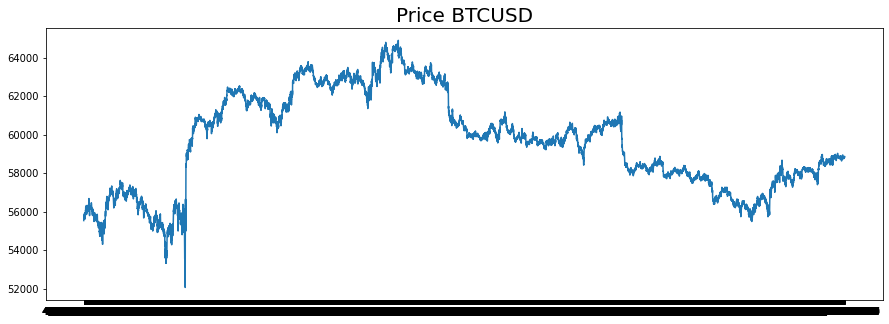

In [ ]:
dates = df['Date'].values
price = df['Close'].values
 
 
plt.figure(figsize = (15,5))
plt.plot(dates, price)
plt.title('Price BTCUSD',
          fontsize=20);

In [96]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [98]:
train_set = windowed_dataset(price,
                             window_size = 60,
                             batch_size = 200,
                             shuffle_buffer = 1000)
 
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences = True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation = "relu"),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1),
])

In [99]:
targetAccuracy = 1150
 
class clbk(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('mae') < targetAccuracy):
      print("\nTarget akurasi telah tercapai!")
      self.model.stop_training = True
callback = clbk()
 
optimizer = tf.keras.optimizers.SGD(learning_rate = 1.0000e-04, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
 
epoch = 100
batch = 128
history = model.fit(train_set,
                    batch_size = batch, 
                    epochs = epoch, 
                    callbacks = [callback])

Epoch 1/100
100/100 [==============================] - 24s 202ms/step - loss: 59642.9492 - mae: 59643.4414
Epoch 2/100
100/100 [==============================] - 21s 206ms/step - loss: 59642.5000 - mae: 59643.0039
Epoch 3/100
100/100 [==============================] - 21s 205ms/step - loss: 59641.8711 - mae: 59642.3438
Epoch 4/100
100/100 [==============================] - 21s 205ms/step - loss: 59640.2578 - mae: 59640.7852
Epoch 5/100
100/100 [==============================] - 21s 203ms/step - loss: 59634.0586 - mae: 59634.5664
Epoch 6/100
100/100 [==============================] - 20s 203ms/step - loss: 59522.5430 - mae: 59523.0508
Epoch 7/100
100/100 [==============================] - 20s 202ms/step - loss: 23248.1602 - mae: 23248.6543
Epoch 8/100
100/100 [==============================] - 20s 203ms/step - loss: 1877.4824 - mae: 1877.9823
Epoch 9/100
100/100 [==============================] - 20s 203ms/step - loss: 1550.0818 - mae: 1550.5817
Epoch 10/100
100/100 [===================

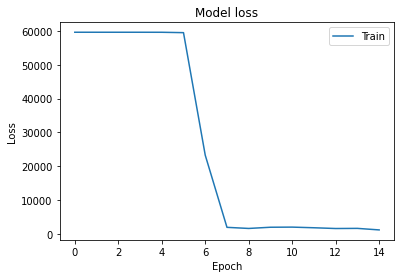

In [100]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper right')
plt.show()

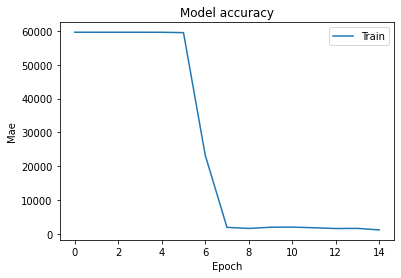

In [101]:
plt.plot(history.history['mae'])
plt.title('Model accuracy')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper right')
plt.show()